# visualdl说明
## [](https://gitee.com/paddlepaddle/VisualDL/blob/develop/docs/faq_CN.md#%E4%BD%BF%E7%94%A8imageaudiotext%E7%BB%84%E4%BB%B6%E4%BB%85%E6%98%BE%E7%A4%BA10%E4%B8%AA%E6%A0%B7%E6%9C%AC)使用Image、Audio、Text组件仅显示10个样本

为保证使用体验，防止由于数据量过大造成前端页面卡死或崩溃，在展示Image、Audio、Text组件时使用采样算法进行了数据采样后展示。
尽管数据在前端展示进行了采样，但在日志中保存的数据仍为全部数据，可通过`VisualDL.LogReader`进行全部数据获取，可参考[LogReader使用教程](https://gitee.com/paddlepaddle/VisualDL/blob/develop/docs/components#LogReader)

## 任务描述：

如何根据据图像的视觉内容为图像赋予一个语义类别是**图像分类**的目标，也是图像检索、图像内容分析和目标识别等问题的基础。

实践内容：利用飞桨动态图搭建一个**卷积神经网络**，对包含斑马线的马路和不包含斑马线的马路图像进行分类。

特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。

In [1]:
from pathlib import Path,PosixPath
import shutil
import pandas as pd
import os
import zipfile
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from paddle.io import Dataset

In [7]:

'''
参数配置
'''
train_parameters = {
    "input_size": [3, 50, 50],                                #输入图片的shape
    "class_dim": 2,                                          #分类数
    "src_path":"data/data55791/Zebra.zip",                    #原始数据集路径
    "target_path":"./data/",                     #要解压的路径
    "train_list_path": "./data/train.txt",       #train.txt路径
    "eval_list_path": "./data/eval.txt",         #eval.txt路径
    "label_dict":{'0':'zebra crossing','1':'others'},         #标签字典
    "num_epochs": 2,                                         #训练轮数
    "train_batch_size": 16,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.01                                            #超参数学习率
    }, 
    'skip_steps': 5,                                         #每N个批次打印一次结果
    'save_steps': 10,                                         #每N个批次保存一次模型参数
    "checkpoints": "./work/checkpoints"          #保存的路径

}


# **一、数据准备**

（1）解压原始数据集

（2）按照比例划分训练集与验证集

（3）乱序，生成数据列表

（4）定义数据读取器

In [ ]:
!pip show pillow

In [ ]:
!pip install --upgrade visualdl  -i https://mirror.baidu.com/pypi/simple

In [14]:
#解压原始数据集
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    print(target_path + "zebra crossing")
    if(not os.path.isdir(target_path + "zebra crossing")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
        print('数据集解压完成')
    else:
        print('文件已存在')

In [15]:
#参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

#解压原始数据到指定路径
unzip_data(src_path,target_path)

./data/zebra crossing
文件已存在


In [16]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
def get_data_list(target_path,label,file_name):
    lst_imgs=[]    
    datas=Path(target_path).glob('*.png')
    datas=list(map(str,datas))
    lst_imgs.extend(zip(datas,[label]*len(datas)))        
    return lst_imgs
     
data1=get_data_list(target_path+"zebra crossing/",0,'train.json')
data2=get_data_list(target_path+"others/",1,'eval.json')
data1.extend(data2)
random.shuffle(data1)
df=pd.DataFrame(data1,columns=['img_path','label'])
df.head()

,img_path,label
0,data\zebra crossing\34.png,0
1,data\others\137.png,1
2,data\others\65.png,1
3,data\others\78.png,1
4,data\zebra crossing\68.png,0


In [17]:
train_data_len=int(len(df)*0.9)
print(df.shape)
train_df=df.iloc[:train_data_len,:]
eval_df=df.iloc[train_data_len:,:]
train_df.to_json("train.json")
eval_df.to_json("eval.json")

(442, 2)


In [18]:
print(train_df.describe())
print(eval_df.describe())

            label
count  397.000000
mean     0.486146
std      0.500439
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000
           label
count  45.000000
mean    0.555556
std     0.502519
min     0.000000
25%     0.000000
50%     1.000000
75%     1.000000
max     1.000000


In [19]:

class dataset(Dataset):
    def __init__(self, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        '''self.data_path = data_path
        self.img_paths = []
        self.labels = []'''
        self.df=pd.read_json(mode+'.json')

        '''
        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))
        '''        


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.df.iloc[index,0]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.df.iloc[index,1]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.df.iloc[index,0], "\t标签值", self.df.iloc[index,1])

    def __len__(self):
        return len(self.df)

In [20]:

#训练数据加载
train_dataset = dataset(mode='train')
train_loader = paddle.io.DataLoader(train_dataset, 
                                    batch_size=train_parameters['train_batch_size'], 
                                    shuffle=True
                                    )
#测试数据加载
eval_dataset = dataset(mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset,
                                   batch_size=train_parameters['train_batch_size'], 
                                   shuffle=False
                                   )

In [21]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 data\zebra crossing\114.png 	标签值 0
397
文件名 data\zebra crossing\119.png 	标签值 0
45
(3, 50, 50)
(1,)


# **二、模型配置**



# 卷积网络示例：
![](https://ai-studio-static-online.cdn.bcebos.com/51015c9299b645d6b6c8256eeddb6e43c87eaf2e05044ddd9f250571343cd687)


In [22]:

#定义卷积网络
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.hidden1 = paddle.nn.Conv2D(in_channels=3,            #通道数
                                            out_channels=32,      #卷积核个数
                                            kernel_size=3,        #卷积核大小
                                            stride=1)             #卷积步长1, 特征图48*48
        self.relu1 = paddle.nn.ReLU()
        self.hidden2 = paddle.nn.Conv2D(in_channels=32,           #通道数
                                            out_channels = 32,   #卷积核个数
                                            kernel_size=3,        #卷积核大小
                                            stride=1)             #卷积步长1, 特征图46*46
        self.hidden3 = paddle.nn.MaxPool2D(kernel_size=2,         #池化核大小
                                            stride=2)             #池化步长2, 特征图23*23
        self.hidden4 = paddle.nn.Linear(32*23*23, 2)
    #网络的前向计算过程
    def forward(self,_input):
        x1 = self.hidden1(_input)
        x2 = self.relu1(x1)        
        x3 = self.hidden2(x2)
        x4 = self.hidden3(x3)        
        x5 = paddle.reshape(x4, shape=[-1, 32*23*23])        
        out = self.hidden4(x5)
        # print("hidden后",out.shape)
        return out,[_input,x1,x2,x3,x4]

# 三、模型训练

In [23]:

def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
def convert_out_img(_img):
    # print(_img.shape)    
    _img=_img.numpy()+1    
    # if len(_img.shape)==3:_img=np.transpose(_img,(1,2,0))
    _img=_img*127.5
    return _img

0
hidden后 [16, 2]
add_image
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
epo: 0, step: 5, loss is: [129.59195], acc is: [0.5]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
epo: 0, step: 10, loss is: [13.872959], acc is: [0.75]
save model to: ./work/checkpoints/save_dir_10.pdparams
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
epo: 0, step: 15, loss is: [7.7745924], acc is: [0.3125]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
epo: 0, step: 20, loss is: [1.555351], acc is: [0.4375]
save model to: ./work/checkpoints/save_dir_20.pdparams
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [13, 2]
epo: 0, step: 25, loss is: [2.0055842], acc is: [0.23076923]
1
hidden后 [16, 2]
add_image
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
hidden后 [16, 2]
epo: 1, step: 30, loss is: [1.3682657], acc is: [0.375]
save model to: ./work/checkpoints/save_dir_30.pd

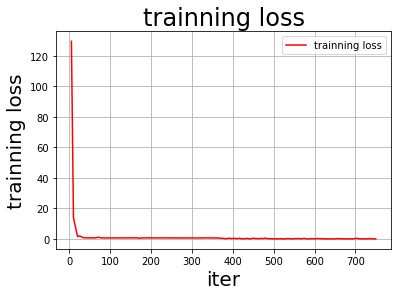

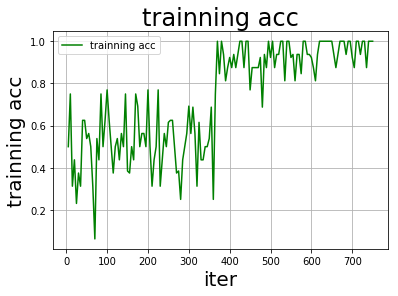

In [42]:
import datetime
from visualdl import LogWriter
model = MyCNN()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 
                                  
steps = 0
Iters, total_loss, total_acc = [], [], []
date_str=datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d_%H%M%S')
log_dir=os.path.join('./log/mycnn',date_str)
log_writer = LogWriter(log_dir)
epochs=train_parameters['num_epochs']
epochs=30
for epo in range(epochs):
    print(epo)
    for batch_id, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts,conv = model(x_data)
        # print('original',conv[0].shape)
        # print('conv1',conv[1].shape)
        # print('conv2',conv[3].shape)
        # print('pool',conv[4].shape)

        if batch_id==0:
            print('add_image')
            # 同时显示一批里的所有图片 # add_image最多记录四个通道，象16,32,220,220不知道怎么显示
            log_writer.add_image(tag='input_mycnn/original', img=convert_out_img(conv[0]),dataformats="NCHW",step=steps)
            log_writer.add_image(tag='input_mycnn/conv1', img=convert_out_img(conv[1][:,:4]),dataformats="NCHW",step=steps)
            log_writer.add_image(tag='input_mycnn/conv2', img=convert_out_img(conv[3][:,:4]),dataformats="NCHW",step=steps)
            log_writer.add_image(tag='input_mycnn/pool', img=convert_out_img(conv[4][:,:4]),dataformats="NCHW",step=steps)


        loss = cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'.format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps) + '.pdparams'
            print('save model to: ' + save_path)
            # paddle.save(model.state_dict(),save_path)
# paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

# 四、模型评估

In [ ]:
'''
模型预测
'''
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_eval = MyCNN()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()
accs = []

for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))


# **五、模型预测**

In [ ]:
def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path)
    # print(img.mode)
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((50, 50), Image.ANTIALIAS)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255  # HWC to CHW 并像素归一化
    return img

In [ ]:

model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_predict = MyCNN()
model_predict.set_state_dict(model__state_dict) 
model_predict.eval()
for file in Path('work').glob('*.jpg'):
    infer_path=file
    infer_img = Image.open(infer_path)
    plt.imshow(infer_img)          #根据数组绘制图像
    plt.show()                     #显示图像
    #对预测图片进行预处理
    infer_img = load_image(infer_path)
    # print(type(infer_img))
    infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,50,50)
    infer_img = paddle.to_tensor(infer_img)
    results = model_predict(infer_img)
    print(results)
    results = paddle.nn.functional.softmax(results)
    print("Zebra crossing:{:.2f}, Others:{:.2f}" .format(results.numpy()[0][0],results.numpy()[0][1]))

In [ ]:
'''
from pathlib import Path
import os
for file in Path('chk_points').iterdir():
    if file.stem=='5':
        continue
    print(file.stem)    
    os.remove(file)
'''    